In [1]:
!pip install featureform==1.12.6
!pip install river -U
!pip install scikit-learn -U
!pip install seaborn
!pip install googleapis-common-protos
!pip install matplotlib
!pip install matplotlib-inline
!pip install ipywidgets

  Obtaining dependency information for featureform==1.12.6 from https://files.pythonhosted.org/packages/f1/88/5a92b1c12b0e6c012112418a8795e4c339bc8036cbd3490afbdaf99fb943/featureform-1.12.6-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 13.7 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: featureform
    Found existing installation: featureform 1.12.6rc0
    Uninstalling featureform-1.12.6rc0:
      Successfully uninstalled featureform-1.12.6rc0

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0

### Start containers

```shell
featureform deploy docker --quickstart --include_clickhouse
```


In [2]:
%env FEATUREFORM_HOST=localhost:7878
%matplotlib inline
from featureform import Client
import featureform as ff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np

# Featureform client. Local instance and insecure
client = Client(insecure=True)
# Register our local container with Featureform
clickhouse = ff.register_clickhouse(
    name="clickhouse",
    description="A ClickHouse deployment for example",
    host="host.docker.internal",
    port=9000,
    user="default",
    password="",
    database="fraud"
)
client.apply(verbose=True)

env: FEATUREFORM_HOST=localhost:7878


Output()

Applying Run: 2024-04-02t18-05-35
Creating provider clickhouse



In [3]:
creditcard = clickhouse.register_table(
    name="creditcard",
    table="creditcard",
)
data = client.dataframe(creditcard, limit=100)
data.info()

Applying Run: 2024-04-02t18-05-36
Creating source creditcard 2024-04-02t18-05-36


Output()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      100 non-null    int64  
 1   V1      100 non-null    float64
 2   V2      100 non-null    float64
 3   V3      100 non-null    float64
 4   V4      100 non-null    float64
 5   V5      100 non-null    float64
 6   V6      100 non-null    float64
 7   V7      100 non-null    float64
 8   V8      100 non-null    float64
 9   V9      100 non-null    float64
 10  V10     100 non-null    float64
 11  V11     100 non-null    float64
 12  V12     100 non-null    float64
 13  V13     100 non-null    float64
 14  V14     100 non-null    float64
 15  V15     100 non-null    float64
 16  V16     100 non-null    float64
 17  V17     100 non-null    float64
 18  V18     100 non-null    float64
 19  V19     100 non-null    float64
 20  V20     100 non-null    float64
 21  V21     100 non-null    float64
 22  V22

In [4]:
# this limited to top 100 rows
data.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,197039.500000,0.777221,-0.568983,0.296377,-0.756414,0.547597,0.401958,0.516153,-0.144970,0.489258,...,-0.102308,0.093818,-0.019819,0.077006,-0.288081,-0.118717,-0.198945,-0.204013,12014.175200,0.0
std,29.011492,0.934286,0.592912,0.594931,0.749759,0.670542,0.742774,0.314289,0.139454,0.525141,...,0.149296,0.752842,0.561610,0.958977,0.797262,1.081306,0.301749,0.698009,7270.023255,0.0
min,196990.000000,-1.088513,-2.777962,-0.521563,-3.377475,-0.428120,-1.444104,-0.448827,-0.811983,-0.697605,...,-0.719382,-1.707431,-3.000634,-2.585125,-1.896197,-3.013168,-1.203315,-4.885553,141.980000,0.0
25%,197014.750000,0.000638,-0.775816,-0.041422,-1.017698,0.201997,-0.047627,0.333685,-0.209888,0.098701,...,-0.196203,-0.509071,-0.207351,-0.388186,-0.871292,-0.659874,-0.318493,-0.240640,5332.427500,0.0
50%,197039.500000,0.690002,-0.444516,0.151557,-0.664594,0.417901,0.262518,0.513593,-0.158030,0.507586,...,-0.090702,0.184429,-0.027612,0.057435,-0.431091,0.115219,-0.252494,-0.174205,12680.095000,0.0
75%,197064.250000,1.741589,-0.187839,0.483623,-0.442668,0.660063,0.743365,0.710923,-0.078027,0.799612,...,-0.024596,0.509730,0.151686,0.703493,0.239219,0.519310,-0.174663,0.038999,18222.392500,0.0
max,197089.000000,2.129746,0.506638,3.512093,1.054738,3.538776,2.701724,1.371970,0.231782,2.068806,...,0.255504,2.100665,3.612639,1.720151,2.342320,2.670707,1.248129,0.806219,24030.140000,0.0


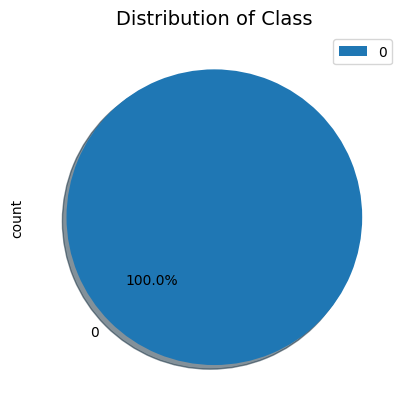

In [5]:
data['Class'].value_counts().plot.pie(autopct='%3.1f%%',shadow=True, legend= True,startangle =45)
plt.title('Distribution of Class',size=14)
plt.show()

Output()

Applying Run: 2024-04-02t18-05-38
Creating source classCounts 2024-04-02t18-05-38



array([<Axes: ylabel='c'>], dtype=object)

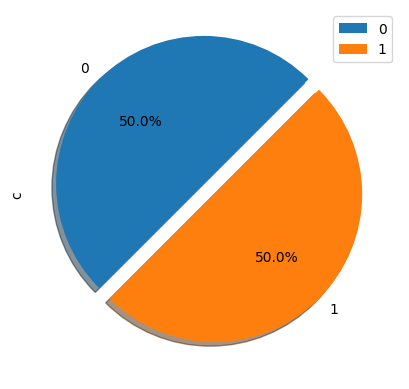

In [6]:
@clickhouse.sql_transformation(inputs=[creditcard])
def classCounts(creditcard):
    return "SELECT Class,count() c FROM {{creditcard}} GROUP BY Class"

client.dataframe(classCounts).pivot_table(index='Class', columns=None, values='c', aggfunc='sum').plot.pie(
    explode=[0.1, 0], autopct='%3.1f%%', shadow=True, legend=True, startangle=45, subplots=True)

In [7]:
import re
@clickhouse.sql_transformation(inputs=[creditcard])
def describe_creditcard(creditcard):
    return "SELECT * APPLY count, * APPLY avg, * APPLY std, * APPLY x -> (quantiles(0.25)(x)[1]), * APPLY x -> (quantiles(0.5)(x)[1]), * APPLY x -> (quantiles(0.75)(x)[1]), * APPLY min, * APPLY max FROM {{creditcard}}"

df = client.dataframe(describe_creditcard, limit=1)
df_melted = df.melt()
df_melted['Var'] = df_melted['variable'].apply(lambda x: re.search(r"\((\w*)\)", x).group(1))
df_melted['Statistic'] = df_melted['variable'].apply(
    lambda x: re.search(r"(.*)\(\w*\)", x).group(1).replace('arrayElement(', ''))
df_melted.pivot(index='Statistic', columns='Var', values='value').reset_index()

Output()

Applying Run: 2024-04-02t18-05-41
Creating source describe_creditcard 2024-04-02t18-05-41



Var,Statistic,Amount,Class,V1,V10,V11,V12,V13,V14,V15,...,V27,V28,V3,V4,V5,V6,V7,V8,V9,id
0,avg,12041.957635,0.5,-4.294068e-17,4.947983e-16,-3.232059e-16,-1.990029e-15,6.144407e-17,1.176924e-15,9.716575e-17,...,-3.501454e-16,2.233957e-16,-3.083141e-16,1.034938e-15,3.585632e-16,1.310288e-15,6.048729e-16,-1.547572e-16,1.439539e-15,284314.500000
1,count,568630.000000,568630.0,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000
2,max,24039.930000,1.0,2.229046e+00,3.172271e+01,2.513573e+00,1.791356e+01,7.187486e+00,1.916954e+01,1.453220e+01,...,1.132311e+02,7.725594e+01,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,568629.000000
3,min,50.010000,0.0,-3.495584e+00,-3.163276e+00,-5.954723e+00,-2.020399e+00,-5.955227e+00,-2.107417e+00,-3.861813e+00,...,-1.049863e+01,-3.903524e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,0.000000
4,quantiles(0.25),6112.400000,0.0,-5.671063e-01,-5.777982e-01,-6.792437e-01,-8.218583e-01,-6.748313e-01,-8.688251e-01,-6.325475e-01,...,-3.082617e-01,-2.339467e-01,-6.566245e-01,-6.766164e-01,-2.974909e-01,-4.537562e-01,-2.753454e-01,-1.883572e-01,-5.775752e-01,145370.750000
5,quantiles(0.5),12242.675000,1.0,-1.103625e-01,2.461934e-01,-3.730834e-02,1.409036e-01,1.312105e-02,2.268537e-01,-5.425710e-02,...,-1.770174e-01,-1.979287e-02,-4.256242e-03,-7.945743e-02,7.875403e-02,8.276375e-02,2.309115e-01,-1.100457e-01,7.203717e-02,286736.500000
6,quantiles(0.75),18132.520000,1.0,7.886171e-01,5.939968e-01,7.469881e-01,7.362465e-01,6.614339e-01,7.382878e-01,6.386682e-01,...,3.436907e-01,4.157551e-01,6.385523e-01,7.111739e-01,4.360106e-01,4.951076e-01,5.234226e-01,4.633178e-02,5.612572e-01,423588.500000
7,stddevPop,6919.638365,0.5,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,164149.341783


In [8]:
@clickhouse.sql_transformation(inputs=[creditcard])
def anynull_creditcard(creditcard):
    return "SELECT * APPLY x -> sum(if(x IS NULL, 1, 0)) FROM {{creditcard}}"

client.dataframe(anynull_creditcard, limit=1).melt()

Output()

Applying Run: 2024-04-02t18-05-43
Creating source anynull_creditcard 2024-04-02t18-05-43



,variable,value
0,"sum(if(isNull(id), 1, 0))",0
1,"sum(if(isNull(V1), 1, 0))",0
2,"sum(if(isNull(V2), 1, 0))",0
3,"sum(if(isNull(V3), 1, 0))",0
4,"sum(if(isNull(V4), 1, 0))",0
5,"sum(if(isNull(V5), 1, 0))",0
6,"sum(if(isNull(V6), 1, 0))",0
7,"sum(if(isNull(V7), 1, 0))",0
8,"sum(if(isNull(V8), 1, 0))",0
9,"sum(if(isNull(V9), 1, 0))",0


In [9]:
@clickhouse.sql_transformation(inputs=[creditcard])
def credit_duplicates(creditcard):
    return "SELECT *, count() AS cnt FROM {{creditcard}} GROUP BY * HAVING cnt > 1"

client.dataframe(credit_duplicates, limit=1)

Output()

Applying Run: 2024-04-02t18-05-45
Creating source credit_duplicates 2024-04-02t18-05-45



,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,cnt


Output()

Applying Run: 2024-04-02t18-05-47
Creating source credit_correlation_matrix 2024-04-02t18-05-47



No resources to apply


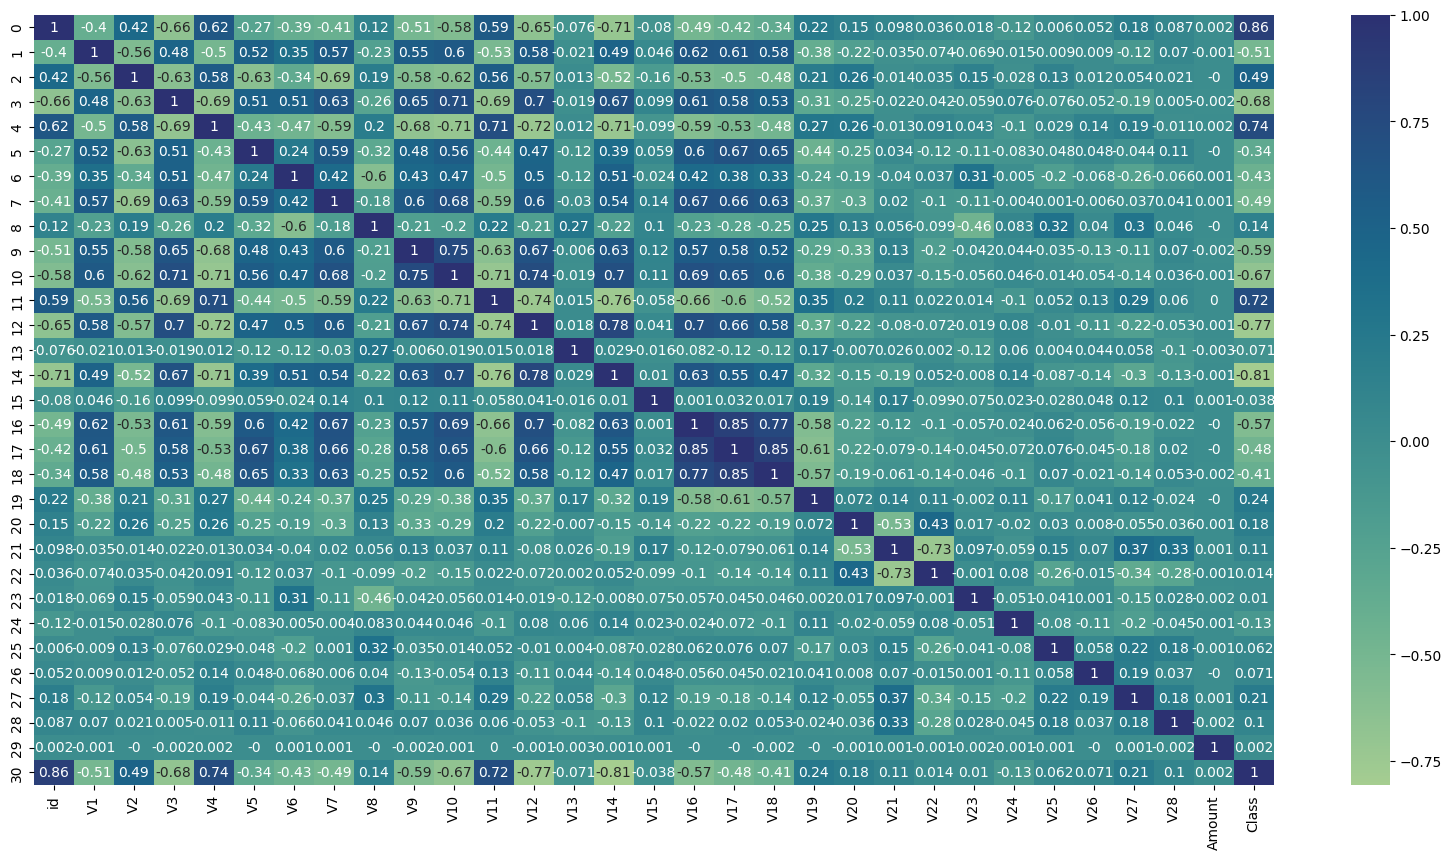

In [10]:
@clickhouse.sql_transformation(inputs=[creditcard])
def credit_correlation_matrix(creditcard):
    return "WITH matrix AS ( SELECT arrayJoin(arrayMap(row -> arrayMap(col -> round(col, 3), row), corrMatrix(id, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class))) AS matrix FROM {{creditcard}}) SELECT matrix[1] AS id, matrix[2] AS V1,matrix[3] AS V2, matrix[4] AS V3, matrix[5] AS V4, matrix[6] AS V5, matrix[7] AS V6, matrix[8] AS V7, matrix[9] AS V8, matrix[10] AS V9, matrix[11] AS V10, matrix[12] AS V11, matrix[13] AS V12, matrix[14] AS V13, matrix[15] AS V14, matrix[16] AS V15, matrix[17] AS V16, matrix[18] AS V17, matrix[19] AS V18, matrix[20] AS V19, matrix[21] AS V20, matrix[22] AS V21, matrix[23] AS V22, matrix[24] AS V23, matrix[25] AS V24, matrix[26] AS V25, matrix[27] AS V26, matrix[28] AS V27, matrix[29] AS V28, matrix[30] AS Amount, matrix[31] AS Class FROM matrix"

client.dataframe(credit_correlation_matrix)
paper = plt.figure(figsize=[20, 10])
sns.heatmap(client.dataframe(credit_correlation_matrix, limit=100), cmap='crest', annot=True)
plt.show()

In [11]:
@clickhouse.sql_transformation(inputs=[creditcard])
def credit_skew(creditcard):
    return "SELECT * APPLY skewSamp FROM {{creditcard}}"

client.dataframe(credit_skew, limit=1).melt()

Output()

Applying Run: 2024-04-02t18-05-49
Creating source credit_skew 2024-04-02t18-05-49



,variable,value
0,skewSamp(id),7.679145e-11
1,skewSamp(V1),-8.341673e-02
2,skewSamp(V2),-1.397945e+00
3,skewSamp(V3),1.462214e-02
4,skewSamp(V4),-4.416869e-02
5,skewSamp(V5),1.506406e+00
6,skewSamp(V6),-2.016099e-01
7,skewSamp(V7),1.902677e+01
8,skewSamp(V8),2.999706e-01
9,skewSamp(V9),1.710566e-01


Output()

Applying Run: 2024-04-02t18-05-52
Creating source amountQuantitles 2024-04-02t18-05-52



<Axes: >

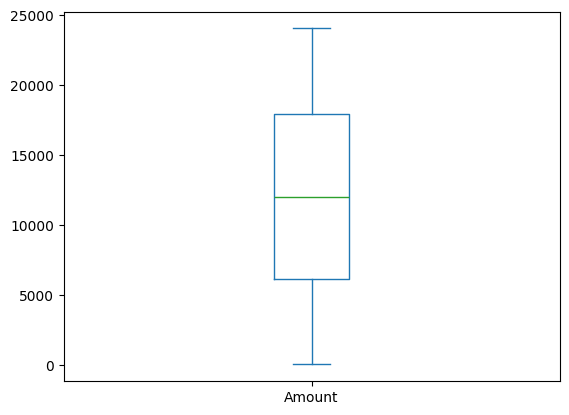

In [12]:
@clickhouse.sql_transformation(inputs=[creditcard])
def amountQuantitles(creditcard):
    return "SELECT arrayJoin(quantiles(0, 0.25, 0.5, 0.75, 1.)(Amount)) AS Amount FROM {{creditcard}}"

client.dataframe(amountQuantitles).plot.box()

Output()

Applying Run: 2024-04-02t18-05-54
Creating source amountSample 2024-04-02t18-05-54



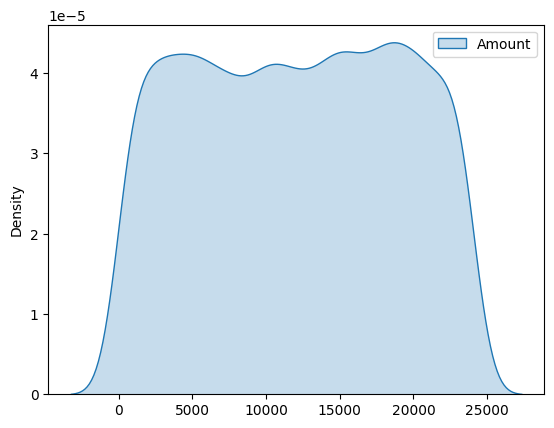

In [13]:
@clickhouse.sql_transformation(inputs=[creditcard])
def amountSample(creditcard):
    return "SELECT Amount FROM {{creditcard}} ORDER BY rand() LIMIT 10000"

sns.kdeplot(data=client.dataframe(amountSample), fill=True)
plt.show()

Applying Run: 2024-04-02t18-05-57
Creating source v20Histogram 2024-04-02t18-05-57
Creating source v10Histogram 2024-04-02t18-05-57
Creating source v12Histogram 2024-04-02t18-05-57


Output()

Creating source v23Histogram 2024-04-02t18-05-57



No resources to apply
No resources to apply
No resources to apply
No resources to apply


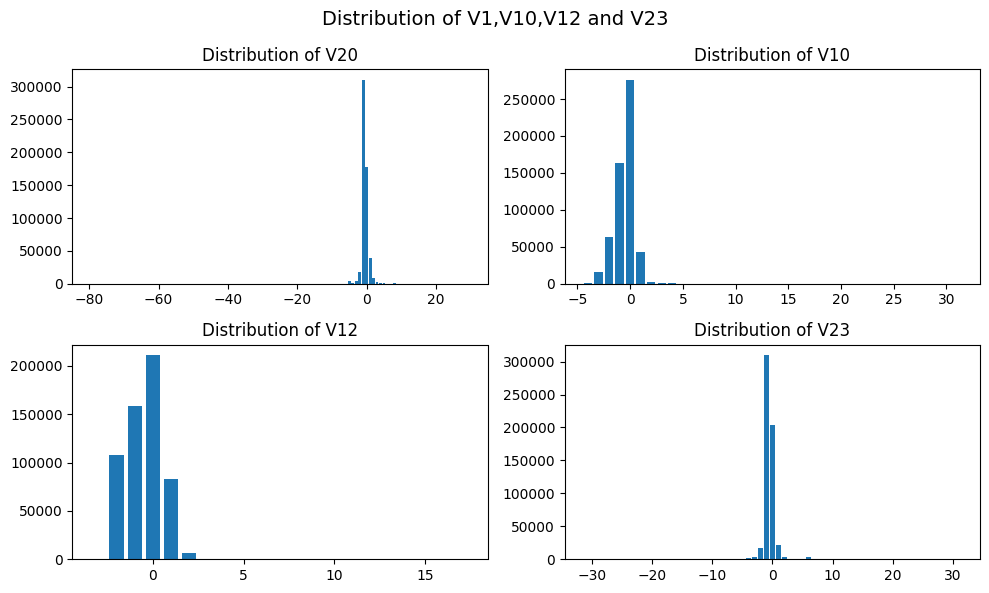

In [14]:
@clickhouse.sql_transformation(inputs=[creditcard])
def v20Histogram(creditcard):
    return "SELECT floor(V20) lower, count() count FROM {{creditcard}} GROUP BY lower ORDER BY lower"

@clickhouse.sql_transformation(inputs=[creditcard])
def v10Histogram(creditcard):
    return "SELECT floor(V10) lower, count() count FROM {{creditcard}} GROUP BY lower ORDER BY lower"

@clickhouse.sql_transformation(inputs=[creditcard])
def v12Histogram(creditcard):
    return "SELECT floor(V12) lower, count() count FROM {{creditcard}} GROUP BY lower ORDER BY lower"

@clickhouse.sql_transformation(inputs=[creditcard])
def v23Histogram(creditcard):
    return "SELECT floor(V23) lower, count() count FROM {{creditcard}} GROUP BY lower ORDER BY lower"

client.apply(verbose=True)
v20h = client.dataframe(v20Histogram)
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes[0, 0].bar(v20h['lower'], v20h['count'], align='center')
axes[0, 0].set_title('Distribution of V20')

v10h = client.dataframe(v10Histogram)
axes[0, 1].bar(v10h['lower'], v10h['count'], align='center')
axes[0, 1].set_title('Distribution of V10')

v12h = client.dataframe(v12Histogram)
axes[1, 0].bar(v12h['lower'], v12h['count'], align='center')
axes[1, 0].set_title('Distribution of V12')

v23h = client.dataframe(v23Histogram)
axes[1, 1].bar(v23h['lower'], v23h['count'], align='center')
axes[1, 1].set_title('Distribution of V23')

fig.suptitle('Distribution of V1,V10,V12 and V23', size=14)
plt.tight_layout()
plt.show()

In [15]:
@clickhouse.sql_transformation(inputs=[creditcard])
def scaled_credit_cards(creditcard):
    column_averages = ', '.join([f'avg(V{i})' for i in range(1, 29)])
    column_std_deviations = ', '.join([f'stddevPop(V{i})' for i in range(1, 29)])
    columns_scaled = ', '.join(f'(V{i} - avgs[{i}]) / stds[{i}] AS V{i}' for i in range(1,29))
    return f"WITH ( SELECT [{column_averages}, avg(Amount)] FROM {{{{creditcard}}}} ) AS avgs, (SELECT [{column_std_deviations}, stddevPop(Amount)] FROM {{{{creditcard}}}}) AS stds SELECT id, { columns_scaled }, (Amount - avgs[29])/stds[29] AS Amount, Class FROM {{{{creditcard}}}}"
client.apply()

Output()

Applying Run: 2024-04-02t18-06-00
Creating source scaled_credit_cards 2024-04-02t18-06-00



In [16]:
sdf = client.dataframe(scaled_credit_cards, limit=100)
sdf.info()

No resources to apply
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      100 non-null    int64  
 1   V1      100 non-null    float64
 2   V2      100 non-null    float64
 3   V3      100 non-null    float64
 4   V4      100 non-null    float64
 5   V5      100 non-null    float64
 6   V6      100 non-null    float64
 7   V7      100 non-null    float64
 8   V8      100 non-null    float64
 9   V9      100 non-null    float64
 10  V10     100 non-null    float64
 11  V11     100 non-null    float64
 12  V12     100 non-null    float64
 13  V13     100 non-null    float64
 14  V14     100 non-null    float64
 15  V15     100 non-null    float64
 16  V16     100 non-null    float64
 17  V17     100 non-null    float64
 18  V18     100 non-null    float64
 19  V19     100 non-null    float64
 20  V20     100 non-null    float64
 21  V21     100 non-nu

In [17]:
@ff.entity
class Transaction:
    # Register multiple columns from a dataset as features
    transaction_features = ff.MultiFeature(
        scaled_credit_cards,
        client.dataframe(scaled_credit_cards, limit=10),
        include_columns=[f"V{i}" for i in range(1, 29)] + ["Amount"],
        entity_column="id",
        exclude_columns=["Class"],
    )
    fraud = ff.Label(
        scaled_credit_cards[["id", "Class"]], type=ff.Bool,
    )

fraud_training_set = ff.register_training_set(
    "fraud_training_set",
    label=Transaction.fraud,
    features=Transaction.transaction_features,
)
client.apply()

No resources to apply
Applying Run: 2024-04-02t18-06-03
Creating entity transaction
Creating feature Amount 2024-04-02t18-06-03
Creating feature V3 2024-04-02t18-06-03
Creating feature V10 2024-04-02t18-06-03
Creating feature V8 2024-04-02t18-06-03
Creating feature V4 2024-04-02t18-06-03
Creating feature V11 2024-04-02t18-06-03
Creating feature V20 2024-04-02t18-06-03
Creating feature V15 2024-04-02t18-06-03
Creating feature V24 2024-04-02t18-06-03
Creating feature V27 2024-04-02t18-06-03
Creating feature V16 2024-04-02t18-06-03
Creating feature V1 2024-04-02t18-06-03
Creating feature V2 2024-04-02t18-06-03
Creating feature V22 2024-04-02t18-06-03
Creating feature V13 2024-04-02t18-06-03
Creating feature V9 2024-04-02t18-06-03
Creating feature V28 2024-04-02t18-06-03
Creating feature V21 2024-04-02t18-06-03
Creating feature V25 2024-04-02t18-06-03
Creating feature V26 2024-04-02t18-06-03
Creating feature V18 2024-04-02t18-06-03
Creating feature V17 2024-04-02t18-06-03
Creating feature 

Output()

In [18]:
ds = client.training_set(fraud_training_set)
train, test = ds.train_test_split(test_size=0.2, train_size=0.8, shuffle=True, random_state=3, batch_size=1000)

# logistical regression but allows incremental training
clf = SGDClassifier(loss='log_loss')
for features, label in train:
    clf.partial_fit(features, label, classes=[True,False])

In [19]:
from sklearn.metrics import confusion_matrix

def model_eval(actual, predicted):
    acc_score = accuracy_score(actual, predicted)
    conf_matrix = confusion_matrix(actual, predicted)
    clas_rep = classification_report(actual, predicted)
    print('Model Accuracy is: ', round(acc_score, 2))
    print(conf_matrix)
    print(clas_rep)

Model Accuracy is:  0.96
[[55414  1366]
 [ 2654 54292]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     56780
         1.0       0.98      0.95      0.96     56946

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726



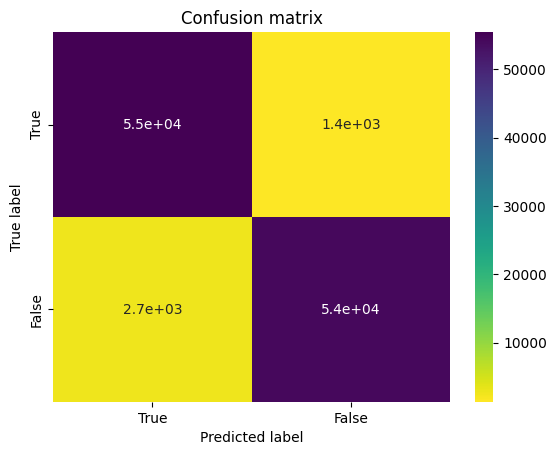

In [20]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    min_val = cm.min()
    max_val = cm.max()
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=True, fmt=".1e", vmin=min_val, vmax=max_val, cmap='viridis_r')
    else:
        sns.heatmap(cm, annot=True, fmt=".1e", vmin=min_val, vmax=max_val, cmap='viridis_r')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
train, test = ds.train_test_split(test_size=0.2, train_size=0.8, shuffle=True, random_state=3, batch_size=1000)

# Make a test prediction
pred_test= np.array([])
label_test = np.array([])
for features, label in test:
    batch_pred = np.array(clf.predict(features))
    pred_test = np.concatenate([pred_test, batch_pred])
    label_test = np.concatenate([label_test, np.array(label)])
model_eval(label_test, pred_test)
cm = confusion_matrix(label_test,  pred_test)
plot_confusion_matrix(cm, classes=[True,False], title='Confusion matrix')

In [ ]:
from river import tree
ds = client.training_set(fraud_training_set)
train, test = ds.train_test_split(test_size=0.2, train_size=0.8, shuffle=True, random_state=3, batch_size=1000)
# Initialize the HoeffdingAdaptiveTreeClassifier
model = tree.HoeffdingAdaptiveTreeClassifier()
# we need to pivot into [({"feature1": value1, "feature2": value2}, label), ...] for the model
feature_names = [t.name for t in Transaction.transaction_features]
n = 0
for features, label in train:
    # Update the model with the current instance
    for i, feature in enumerate(features):
        feature_dict = dict(zip(feature_names, feature))
        model.learn_one(feature_dict, label[i])
        n += 1
    print(f'{n} processed')

Model Accuracy is:  0.98
[[55140  1640]
 [ 1110 55836]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     56780
           1       0.97      0.98      0.98     56946

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726



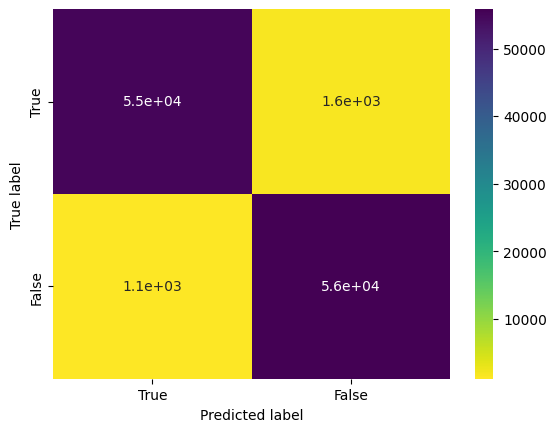

In [23]:
predicted_labels = []
actual_labels = []
train, test = ds.train_test_split(test_size=0.2, train_size=0.8, shuffle=True, random_state=3, batch_size=1000)
for features, label in test:
    for i, feature in enumerate(features):
        feature_dict = dict(zip(feature_names, feature))
        predicted_labels.append(model.predict_one(feature_dict))
        actual_labels.append(label[i])
# Evaluate the model
model_eval(actual_labels, predicted_labels)
# Plot the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
plot_confusion_matrix(cm, classes=[True, False], title='')